In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as T
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'
    
modelname = "densenet121"

Available workers: 16


# Creating train,val,test sets

## Removing outliers

In [3]:
df = pd.read_parquet(f"{SAVE_DIR}/df_preparation_{setting}.parquet")
# df = pd.merge(df,df_pre, on=['filename','platename','imgname','date','year','plate_idx','location','xtra'])
# df = df[df.knn_outlier==0]
# df = df[df.nb_contours>0]
# print(df.label.unique())

oe = OrdinalEncoder(cols=['label'],mapping=[{'col':'label', 'mapping':{'bl':0,'wswl':1,'sp':2,'t':3,'sw':4,'k':5,'m':6,'c':7,'v':8,'wmv':9,'wrl':10,'other':11}}])
df['txt_label'] = df['label']
df['label'] = oe.fit_transform(df.label)
df.label.value_counts()

8     5556
9     5285
7     4571
4     2532
3     2386
0     2332
6     1547
5     1082
10    1016
2      795
1      682
11     573
Name: label, dtype: int64

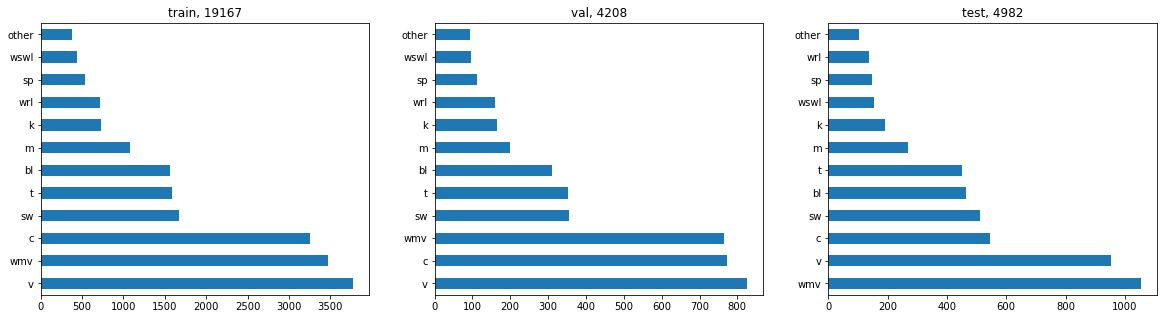

In [4]:
test_plates = train_test_split(df.platename.unique(), random_state=2022, test_size=0.2, shuffle=True)[1].tolist()
testseries = pd.Series(test_plates)
inds = testseries.apply(lambda x: 'wortel' in x)
inds = testseries[inds].sample(11).index.values
wortel_plates = testseries[inds].tolist()
test_plates = testseries[testseries.apply(lambda x: x.split('_')[1] != 'wortel')].tolist() + wortel_plates

df_trainval = df[~df.platename.isin(test_plates)]
df_test = df[df.platename.isin(test_plates)]

topclasses = df['label'].value_counts().head(12).index.tolist()

df = df[df['label'].isin(topclasses)]
df_trainval = df_trainval[df_trainval['label'].isin(topclasses)]
df_test = df_test[df_test['label'].isin(topclasses)]

class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(df['label'].tolist()), 
                                                  y=df['label'].tolist())

class_weights = {np.unique(df['label'])[i]:class_weights[i] for i in range(len(class_weights))}
df['weights'] = df['label'].map(class_weights)

df_train, df_val = train_test_split(df_trainval, test_size=0.18, random_state=42, shuffle=True)


plt.figure(figsize=(20,5))
plt.subplot(1,3,1);df_train.txt_label.value_counts().plot(kind='barh');plt.title(f'train, {df_train.shape[0]}')
plt.subplot(1,3,2);df_val.txt_label.value_counts().plot(kind='barh');plt.title(f'val, {df_val.shape[0]}')
plt.subplot(1,3,3);df_test.txt_label.value_counts().plot(kind='barh');plt.title(f'test, {df_test.shape[0]}');

In [5]:
assert len(set(df_train.filename.tolist()).intersection(df_test.filename.tolist())) == 0
assert len(set(df_train.filename.tolist()).intersection(df_val.filename.tolist())) == 0

In [6]:
df_train.to_parquet(f"{SAVE_DIR}/df_train_{setting}.parquet")
df_val.to_parquet(f"{SAVE_DIR}/df_val_{setting}.parquet")
df_test.to_parquet(f"{SAVE_DIR}/df_test_{setting}.parquet")

In [7]:
df_train.label.value_counts()

8     3776
9     3466
7     3254
4     1665
3     1581
0     1558
6     1079
5      725
10     720
2      535
1      433
11     375
Name: label, dtype: int64

# Creating Pytorch Datasets and Dataloaders

In [8]:
transforms_list_train = [
#     A.SmallestMaxSize(max_size=150),
    T.ToPILImage(),
    T.Resize(size=(150,150)),
    T.RandomVerticalFlip(p=0.5),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomAutocontrast(p=0.5),
    T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.5),
    T.RandomRotation(degrees=(-15,15)),
    T.RandomPosterize(bits=7, p=0.1),
    # T.RandomEqualize(p=0.5),
    T.ToTensor(),
]

transforms_list_test = [
    T.ToPILImage(),
    T.Resize(size=(150,150)),    
    T.ToTensor(),
]

train_dataset = InsectImgDataset(df=df_train.reset_index(drop=True), transform=T.Compose(transforms_list_train))
valid_dataset = InsectImgDataset(df=df_val.reset_index(drop=True), transform=T.Compose(transforms_list_test))
test_dataset = InsectImgDataset(df=df_test.reset_index(drop=True), transform=T.Compose(transforms_list_test))

batch_size = 32
batch_size_val = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

# plt.imshow(train_dataset[0][0]); plt.title(f"Example train image, class:{train_dataset[0][1]}");

In [9]:
tensor_image = train_dataset[150][0]
# print(tensor_image)
# plt.imshow(  tensor_image.permute(1, 2, 0)  )
# print(tensor_image.permute(1, 2, 0).shape)

#### Defining the model and training parameters

In [10]:
torch.backends.cudnn.benchmark = True

In [11]:
model = model_selector(modelname, pretrained=True)

if modelname.startswith("dense"):
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
                            nn.Linear(num_ftrs,512),
                            nn.ReLU(),
                            nn.Dropout(0.3),
                            nn.Linear(512, len(topclasses)))
if modelname.startswith("resn"):
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("efficient"):
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("vgg"):
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, len(topclasses))
if modelname.startswith("mobile"):
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, len(topclasses))

In [12]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

num_epochs = 150

class_sample_count = np.unique(df_train.label, return_counts=True)[1]
weight = 1. / class_sample_count  
criterion = nn.CrossEntropyLoss(label_smoothing=.15, weight=torch.Tensor(weight).cuda())

Train on gpu: True


In [13]:
optimizer = optim.AdamW(model.parameters(), lr=.003, weight_decay=0.01)#optim.Adam(model.parameters(), lr=.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0003, max_lr=0.03, cycle_momentum=False, mode="triangular2")

In [14]:
#optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")

# Training

In [ ]:
results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
best_valacc = 0
# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(train_dataloader, desc='Training..\t'):        
        y_batch = torch.as_tensor(y_batch)
        x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
        for param in model.parameters():
            param.grad = None
        pred = model(x_batch)

        y_batch = y_batch.type(torch.LongTensor).cuda()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
    train_accuracy = correct_train / len(train_dataset) * 100.
    torch.cuda.empty_cache()

    
    # Going through the validation set
    correct_valid = 0
    model.eval()
    with torch.no_grad():
        for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(valid_dataloader, desc='Validating..\t'):
            y_batch = torch.as_tensor(y_batch)
            x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
            pred = model(x_batch)

            y_batch = y_batch.type(torch.LongTensor).cuda()
            correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
            val_loss = criterion(pred, y_batch)
    valid_accuracy = correct_valid / len(valid_dataset) * 100.

    scheduler.step()


    # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")
        
    is_best = valid_accuracy > best_valacc
    if is_best:
        print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
    best_valacc = max(valid_accuracy, best_valacc)
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_valacc': best_valacc,
        'loss': results['loss'].append(loss.detach().cpu()),
        'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
        'train_accuracy': results['train_accuracy'].append(train_accuracy),
        'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
        'optimizer' : optimizer.state_dict(),
    }, is_best, f"{modelname}_{setting}")


Training..	: 100%|█| 599/599 [01:33<00:
Validating..	: 100%|█| 132/132 [00:05<0


Epoch 0: train_acc: 54.3% loss: 2.4670353,  val_loss: 2.4352551 val_acc: 65.8%
Validation accuracy improved from 0.00 to 65.78. Saving model..


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 1: train_acc: 66.9% loss: 1.5612895,  val_loss: 2.3157458 val_acc: 71.5%
Validation accuracy improved from 65.78 to 71.46. Saving model..


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 2: train_acc: 70.2% loss: 1.8248601,  val_loss: 2.3254249 val_acc: 71.6%
Validation accuracy improved from 71.46 to 71.63. Saving model..


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 3: train_acc: 72.4% loss: 1.6432574,  val_loss: 2.3904078 val_acc: 69.5%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 4: train_acc: 73.7% loss: 1.3933077,  val_loss: 2.4338040 val_acc: 72.0%
Validation accuracy improved from 71.63 to 72.01. Saving model..


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 5: train_acc: 75.1% loss: 1.6739149,  val_loss: 1.9977612 val_acc: 74.5%
Validation accuracy improved from 72.01 to 74.50. Saving model..


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 6: train_acc: 75.5% loss: 1.4886177,  val_loss: 1.6787994 val_acc: 75.5%
Validation accuracy improved from 74.50 to 75.48. Saving model..


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 7: train_acc: 76.4% loss: 1.5750871,  val_loss: 2.3484585 val_acc: 68.4%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 8: train_acc: 76.4% loss: 1.5412450,  val_loss: 2.4051538 val_acc: 74.3%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 9: train_acc: 77.5% loss: 1.2868366,  val_loss: 1.8626437 val_acc: 76.2%
Validation accuracy improved from 75.48 to 76.24. Saving model..


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 10: train_acc: 77.8% loss: 1.9402486,  val_loss: 2.2223568 val_acc: 72.5%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 11: train_acc: 77.5% loss: 1.4247080,  val_loss: 2.1923354 val_acc: 77.5%
Validation accuracy improved from 76.24 to 77.47. Saving model..


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 12: train_acc: 78.5% loss: 1.4024825,  val_loss: 2.4394984 val_acc: 76.6%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 13: train_acc: 78.2% loss: 1.7868069,  val_loss: 2.8766458 val_acc: 78.2%
Validation accuracy improved from 77.47 to 78.23. Saving model..


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 14: train_acc: 79.1% loss: 1.5064489,  val_loss: 2.4612722 val_acc: 74.2%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 15: train_acc: 78.6% loss: 1.4899819,  val_loss: 2.0677450 val_acc: 75.2%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 16: train_acc: 79.3% loss: 1.4086256,  val_loss: 2.1844676 val_acc: 78.9%
Validation accuracy improved from 78.23 to 78.94. Saving model..


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 17: train_acc: 79.6% loss: 1.6762719,  val_loss: 2.2523179 val_acc: 76.1%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 18: train_acc: 80.1% loss: 1.9024367,  val_loss: 2.2999103 val_acc: 79.4%
Validation accuracy improved from 78.94 to 79.42. Saving model..


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:06<0


Epoch 19: train_acc: 80.3% loss: 2.0113425,  val_loss: 2.4551570 val_acc: 78.7%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 20: train_acc: 80.8% loss: 1.4119196,  val_loss: 2.3673782 val_acc: 79.0%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 21: train_acc: 80.2% loss: 1.7477851,  val_loss: 2.1127954 val_acc: 79.9%
Validation accuracy improved from 79.42 to 79.94. Saving model..


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 22: train_acc: 80.7% loss: 1.0553067,  val_loss: 2.3308818 val_acc: 73.4%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 23: train_acc: 81.0% loss: 1.5421374,  val_loss: 2.1547580 val_acc: 69.0%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 24: train_acc: 81.2% loss: 1.4281609,  val_loss: 2.4444442 val_acc: 78.9%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 25: train_acc: 81.1% loss: 1.5363019,  val_loss: 2.2200623 val_acc: 78.6%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 26: train_acc: 81.6% loss: 1.3909967,  val_loss: 2.4199574 val_acc: 79.3%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 27: train_acc: 81.1% loss: 1.2945648,  val_loss: 2.1282959 val_acc: 76.8%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 28: train_acc: 81.8% loss: 1.5741607,  val_loss: 2.4425120 val_acc: 78.6%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 29: train_acc: 81.8% loss: 1.2693653,  val_loss: 2.2973661 val_acc: 78.4%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 30: train_acc: 82.3% loss: 1.1876445,  val_loss: 2.0466552 val_acc: 78.1%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 31: train_acc: 82.8% loss: 1.5256045,  val_loss: 2.1272738 val_acc: 78.1%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 32: train_acc: 82.3% loss: 1.6401227,  val_loss: 2.1669052 val_acc: 79.3%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 33: train_acc: 82.0% loss: 1.6834036,  val_loss: 2.1171131 val_acc: 79.9%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 34: train_acc: 82.7% loss: 1.8492219,  val_loss: 2.1124330 val_acc: 79.4%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 35: train_acc: 83.4% loss: 1.6194532,  val_loss: 2.2844763 val_acc: 77.1%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 36: train_acc: 82.8% loss: 1.1703136,  val_loss: 2.0123310 val_acc: 67.4%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 37: train_acc: 82.9% loss: 1.2767519,  val_loss: 2.2624164 val_acc: 79.3%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 38: train_acc: 83.5% loss: 1.2791638,  val_loss: 2.2267475 val_acc: 78.4%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 39: train_acc: 83.4% loss: 1.4892905,  val_loss: 2.2792115 val_acc: 77.2%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 40: train_acc: 82.8% loss: 1.7807686,  val_loss: 2.0622034 val_acc: 79.7%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 41: train_acc: 83.4% loss: 1.3372464,  val_loss: 2.2408190 val_acc: 70.6%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 42: train_acc: 84.3% loss: 1.3567251,  val_loss: 2.1308968 val_acc: 77.9%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 43: train_acc: 84.1% loss: 1.5557072,  val_loss: 2.2522523 val_acc: 78.6%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 44: train_acc: 83.6% loss: 1.3953518,  val_loss: 2.1710713 val_acc: 76.0%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 45: train_acc: 84.0% loss: 1.0702257,  val_loss: 2.4582882 val_acc: 78.6%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 46: train_acc: 84.5% loss: 1.4503120,  val_loss: 2.1620665 val_acc: 79.0%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 47: train_acc: 84.3% loss: 1.9102366,  val_loss: 2.1452804 val_acc: 81.8%
Validation accuracy improved from 79.94 to 81.84. Saving model..


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 48: train_acc: 84.3% loss: 1.4294086,  val_loss: 2.6727953 val_acc: 76.7%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 49: train_acc: 84.4% loss: 1.5609522,  val_loss: 2.3568261 val_acc: 77.2%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 50: train_acc: 84.2% loss: 1.4377315,  val_loss: 2.0943749 val_acc: 79.3%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 51: train_acc: 85.3% loss: 1.5200433,  val_loss: 2.3840456 val_acc: 77.8%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 52: train_acc: 85.4% loss: 1.3128558,  val_loss: 2.4572585 val_acc: 76.0%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 53: train_acc: 84.8% loss: 1.4825182,  val_loss: 2.5199652 val_acc: 72.1%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 54: train_acc: 85.0% loss: 1.1967986,  val_loss: 2.2947283 val_acc: 74.3%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 55: train_acc: 85.3% loss: 1.3137126,  val_loss: 2.0851495 val_acc: 78.1%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 56: train_acc: 85.3% loss: 1.1783874,  val_loss: 2.2637906 val_acc: 78.6%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 57: train_acc: 85.5% loss: 1.3036629,  val_loss: 2.4172683 val_acc: 76.3%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 58: train_acc: 85.5% loss: 1.2331626,  val_loss: 2.5086966 val_acc: 81.0%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 59: train_acc: 85.6% loss: 1.6193457,  val_loss: 2.2422876 val_acc: 80.4%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 60: train_acc: 86.1% loss: 1.3258440,  val_loss: 2.3628392 val_acc: 77.1%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 61: train_acc: 85.5% loss: 1.0404156,  val_loss: 2.2188587 val_acc: 79.9%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 62: train_acc: 86.3% loss: 1.1991652,  val_loss: 2.3285215 val_acc: 74.5%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 63: train_acc: 85.5% loss: 1.5032041,  val_loss: 2.3764856 val_acc: 80.2%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 64: train_acc: 85.9% loss: 1.0834506,  val_loss: 2.5096972 val_acc: 80.5%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 65: train_acc: 86.3% loss: 1.3806450,  val_loss: 2.4304473 val_acc: 69.9%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 66: train_acc: 86.5% loss: 1.6390002,  val_loss: 2.3142085 val_acc: 76.9%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 67: train_acc: 86.0% loss: 1.4059424,  val_loss: 2.0912509 val_acc: 79.0%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 68: train_acc: 85.7% loss: 1.0552150,  val_loss: 2.4843369 val_acc: 79.9%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 69: train_acc: 86.7% loss: 1.4818560,  val_loss: 2.3714194 val_acc: 79.9%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 70: train_acc: 86.7% loss: 0.9229661,  val_loss: 2.2160680 val_acc: 80.5%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 71: train_acc: 86.6% loss: 1.7912600,  val_loss: 2.3396850 val_acc: 77.3%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 72: train_acc: 86.4% loss: 1.3854504,  val_loss: 2.6284025 val_acc: 80.3%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 73: train_acc: 87.0% loss: 1.3386583,  val_loss: 2.2243338 val_acc: 77.8%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 74: train_acc: 86.8% loss: 1.2558603,  val_loss: 1.9830875 val_acc: 81.4%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 75: train_acc: 87.1% loss: 1.7909400,  val_loss: 2.2130303 val_acc: 78.8%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 76: train_acc: 86.7% loss: 1.1489722,  val_loss: 2.2186241 val_acc: 76.9%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 77: train_acc: 86.9% loss: 1.2917233,  val_loss: 2.2712307 val_acc: 79.5%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 78: train_acc: 86.6% loss: 1.2361439,  val_loss: 2.0402160 val_acc: 78.7%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 79: train_acc: 87.7% loss: 1.2943685,  val_loss: 2.3800385 val_acc: 79.0%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 80: train_acc: 87.1% loss: 1.3580145,  val_loss: 2.2917893 val_acc: 79.4%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 81: train_acc: 86.9% loss: 1.3664140,  val_loss: 2.3131819 val_acc: 79.4%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 82: train_acc: 86.6% loss: 1.4381049,  val_loss: 2.0618687 val_acc: 81.5%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 83: train_acc: 87.6% loss: 1.6098567,  val_loss: 2.1425974 val_acc: 81.5%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 84: train_acc: 87.1% loss: 1.3862150,  val_loss: 2.5746810 val_acc: 80.8%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 85: train_acc: 87.5% loss: 1.2470887,  val_loss: 2.2952356 val_acc: 78.3%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 86: train_acc: 87.6% loss: 1.5881326,  val_loss: 2.5888913 val_acc: 76.4%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 87: train_acc: 87.2% loss: 1.3117845,  val_loss: 2.3994501 val_acc: 78.9%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 88: train_acc: 87.4% loss: 1.4325302,  val_loss: 2.2567589 val_acc: 78.6%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 89: train_acc: 87.4% loss: 1.2990222,  val_loss: 2.2919393 val_acc: 79.6%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 90: train_acc: 87.6% loss: 1.4601079,  val_loss: 2.0344362 val_acc: 75.1%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 91: train_acc: 87.4% loss: 1.5653534,  val_loss: 2.2637205 val_acc: 76.4%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 92: train_acc: 87.6% loss: 1.4749408,  val_loss: 2.4238083 val_acc: 79.5%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 93: train_acc: 87.9% loss: 1.2872075,  val_loss: 2.1690686 val_acc: 76.0%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 94: train_acc: 88.0% loss: 1.4149505,  val_loss: 2.2197273 val_acc: 81.5%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 95: train_acc: 86.5% loss: 2.0795803,  val_loss: 2.5896037 val_acc: 76.1%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 96: train_acc: 87.7% loss: 1.5629253,  val_loss: 2.4898062 val_acc: 75.4%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 97: train_acc: 88.0% loss: 1.2174811,  val_loss: 2.2524211 val_acc: 78.9%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 98: train_acc: 88.5% loss: 1.1533009,  val_loss: 2.2013829 val_acc: 79.4%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 99: train_acc: 88.2% loss: 1.1644342,  val_loss: 2.3167651 val_acc: 77.6%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 100: train_acc: 88.0% loss: 1.5548573,  val_loss: 2.0789745 val_acc: 81.0%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 101: train_acc: 88.5% loss: 1.6071128,  val_loss: 2.6882062 val_acc: 80.8%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 102: train_acc: 87.5% loss: 1.4517212,  val_loss: 2.2365193 val_acc: 81.5%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 103: train_acc: 88.3% loss: 1.1709218,  val_loss: 2.2999518 val_acc: 78.0%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 104: train_acc: 88.0% loss: 1.4348365,  val_loss: 2.2181833 val_acc: 79.4%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 105: train_acc: 88.6% loss: 1.5823216,  val_loss: 2.2761245 val_acc: 78.7%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 106: train_acc: 87.2% loss: 1.2845430,  val_loss: 2.1482785 val_acc: 78.5%


Training..	: 100%|█| 599/599 [01:19<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 107: train_acc: 88.6% loss: 1.6993129,  val_loss: 2.3076918 val_acc: 78.2%


Training..	: 100%|█| 599/599 [01:20<00:
Validating..	: 100%|█| 132/132 [00:05<0


Epoch 108: train_acc: 88.5% loss: 1.1936299,  val_loss: 2.4963398 val_acc: 79.8%


Training..	: 100%|█| 599/599 [01:21<00:
Validating..	: 100%|█| 132/132 [00:05<0


Epoch 109: train_acc: 89.0% loss: 1.6109855,  val_loss: 2.7290330 val_acc: 78.9%


Training..	: 100%|█| 599/599 [01:21<00:
Validating..	: 100%|█| 132/132 [00:04<0


Epoch 110: train_acc: 88.3% loss: 1.0715100,  val_loss: 2.1822560 val_acc: 77.9%


Training..	: 100%|█| 599/599 [11:25<00:
Validating..	: 100%|█| 132/132 [01:04<0


Epoch 111: train_acc: 88.6% loss: 1.0566778,  val_loss: 2.4988098 val_acc: 77.2%


Training..	: 100%|█| 599/599 [02:36<00:
Validating..	: 100%|█| 132/132 [00:05<0


Epoch 112: train_acc: 88.7% loss: 1.4412661,  val_loss: 2.0568917 val_acc: 76.9%


Training..	: 100%|█| 599/599 [01:27<00:
Validating..	: 100%|█| 132/132 [00:05<0


Epoch 113: train_acc: 88.9% loss: 1.0148495,  val_loss: 2.2926202 val_acc: 77.5%


Training..	: 100%|█| 599/599 [01:22<00:
Validating..	: 100%|█| 132/132 [00:05<0


Epoch 114: train_acc: 88.9% loss: 1.4449780,  val_loss: 2.1662302 val_acc: 77.1%


Training..	:  88%|▉| 530/599 [01:11<00:

In [16]:
x_batch[0].shape

torch.Size([3, 150, 150])

In [17]:
train_dataset